In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Documents/Github/DriftDiffusionModels.jl`


In [2]:
using DriftDiffusionModels
using Plots
using StatsBase
using JLD2
using Printf
using Dates
using Random
using Distributions
using UnPack
using LsqFit

#### Simulate 1000 trials: 9000 from DDM, 1000 from Uniform, pool together

In [50]:
B = 6.0
v = 0.23
α₀ = 0.5 # fixed
τ = 0.25
σ = 1.0 # fixed

# emission
ddm = DriftDiffusionModel(B, v, α₀, τ, σ)

ddm_data = simulateDDM(ddm, 9000, 1e-6);

# choose rt uniform from (0, τ)
rt = rand(Uniform(0, τ))

# sample data from ddm
function simulateDDM_with_uniform_τ(
    model::DriftDiffusionModel,
    n::Int,
    rng::AbstractRNG = Random.default_rng()
)
    @unpack B, v, a₀, τ, σ = model
    dt = 1e-5
    results = DDMResult[]

    for _ in 1:n
        # Sample Non-decision time with uniform [0, τ]
        τ_uniform = rand(Uniform(0, 0.3))
        choice = rand(rng, Bool) ? 1 : -1  

        push!(results, DDMResult(τ_uniform, choice))
    end

    return results
end

uniform_data = simulateDDM_with_uniform_τ(ddm, 1000)

pooled_data = vcat(uniform_data, ddm_data)

rts = [d.rt for d in data]
choices = [d.choice for d in data]

println("Generated Data")

Generated Data


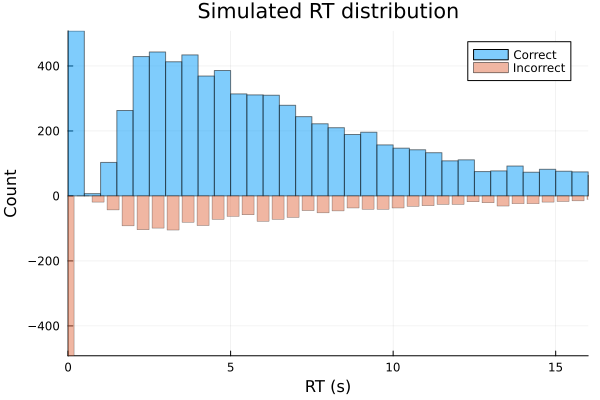

In [67]:
correct_trials = [x for x in pooled_data if x.choice == 1]
incorrect_trials = [x for x in pooled_data if x.choice == -1];

rt_dist_plot = histogram([x.rt for x in correct_trials], bins=130, alpha=0.5, label="Correct", legend=:topright)
incorrect_rts = [x.rt for x in incorrect_trials]
h = fit(Histogram, incorrect_rts, range(0, maximum(incorrect_rts), length=101))
bar!(h.edges[1][1:end-1], -h.weights, width=step(h.edges[1]), 
     alpha=0.5, 
     label="Incorrect")
# Adjust y-axis to make room for the downward bars
xlabel!("RT (s)")
ylabel!("Count")
title!("Simulated RT distribution")
# ylims!(minimum([-h.weights; 0]) * 1.1, maximum(h.weights) * )
xlims!(0, 16)


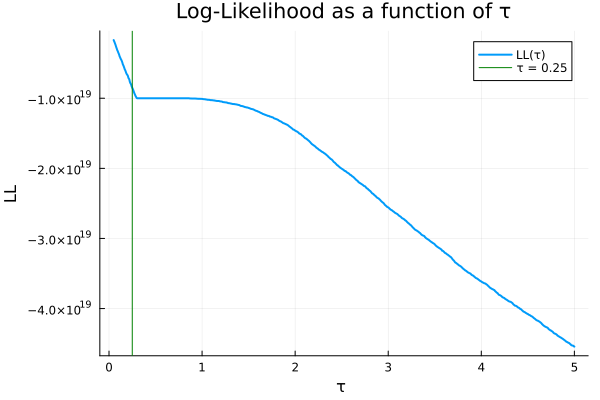

In [111]:
τ_range = range(0.05, 5; length=1000)

log_likelihoods = [
    sum(logdensityof(B, v, α₀, τ_obs, σ, d.rt, d.choice) for d in pooled_data)
    for τ_obs in τ_range
]

plot(
    τ_range, log_likelihoods;
    xlabel = "τ ",
    ylabel = "LL",
    title  = "Log-Likelihood as a function of τ",
    label  = "LL(τ)",
    lw = 2,
)

vline!([0.25]; color=:green, label="τ = $τ")

#### Fit a sigmoid function to the lls 

In [130]:
τ_range = range(0.05, 0.7; length=1000)
τ_vec = collect(τ_range)

log_likelihoods_centered = log_likelihoods .- maximum(log_likelihoods)

function log_sigmoid_model(τ, params)
    t, k, A, B = params
    @. A / (1 + exp(-k * (τ - t))) + B
end

τ_threshold = 0.27
fit_mask = τ_vec .<= τ_threshold
τ_fit = τ_vec[fit_mask]
ll_fit = log_likelihoods_centered[fit_mask]

A0 = (maximum(ll_fit) - minimum(ll_fit)) / 2
B0 = minimum(ll_fit)
init_params = [0.25, 50.0, A0, B0]

fit_result = curve_fit(log_sigmoid_model, τ_fit, ll_fit, init_params)
t_fit, k_fit, A_fit, B_fit = fit_result.param

println("fitted params")
println("t = $t_fit")
println("k = $k_fit")
println("A = $A_fit")
println("B = ", B_fit + maximum(log_likelihoods))

fitted params
t = 0.05871358729352486
k = 89.11745799380662
A = -1.3141718147602377e19
B = 2.5044048723648026e18


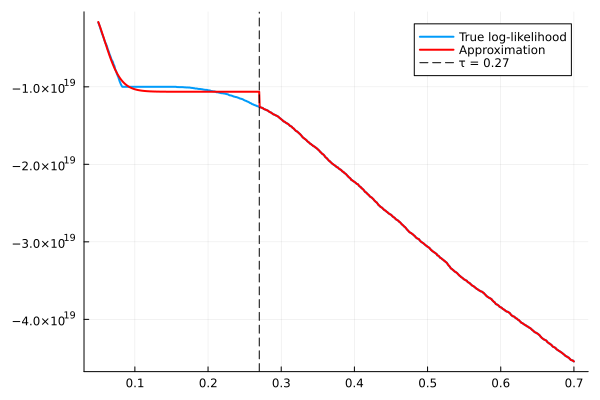

In [131]:
logsigmoid_fit = log_sigmoid_model(τ_vec, fit_result.param) .+ maximum(log_likelihoods)
ll_combined = similar(logsigmoid_fit)

for i in eachindex(τ_vec)
    if τ_vec[i] <= τ_threshold
        ll_combined[i] = logsigmoid_fit[i]
    else
        ll_combined[i] = log_likelihoods[i]
    end
end


# 7. Plot
plot(τ_range, log_likelihoods; label="True log-likelihood", lw=2)
plot!(τ_range, ll_combined; label="Approximation", color=:red, lw=2)
vline!([τ_threshold]; linestyle=:dash, color=:black, label="τ = $τ_threshold")